# analyze GPA

## exploding losses
In many cases, including the standard settings, the model is not able to train. After only a few epochs, the losses explode. Simply reducing the influence of the domain adaptation let's the model train, but doesn't lead to any improvement.

[{'bbox_mAP_50': (4.0, 0.839)}, {'bbox_mAP_50': (6.0, 0.85)}]


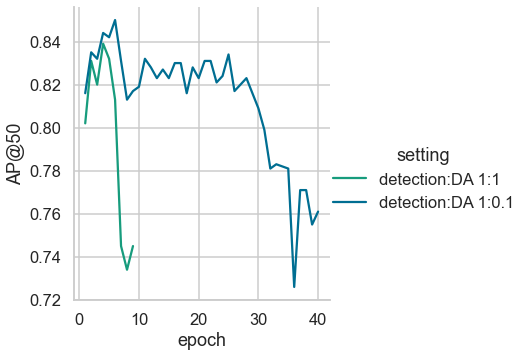

In [48]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'detection:DA 1:1'],
        ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'detection:DA 1:0.1'],# -> can't decrease intra-losses
]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=40], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

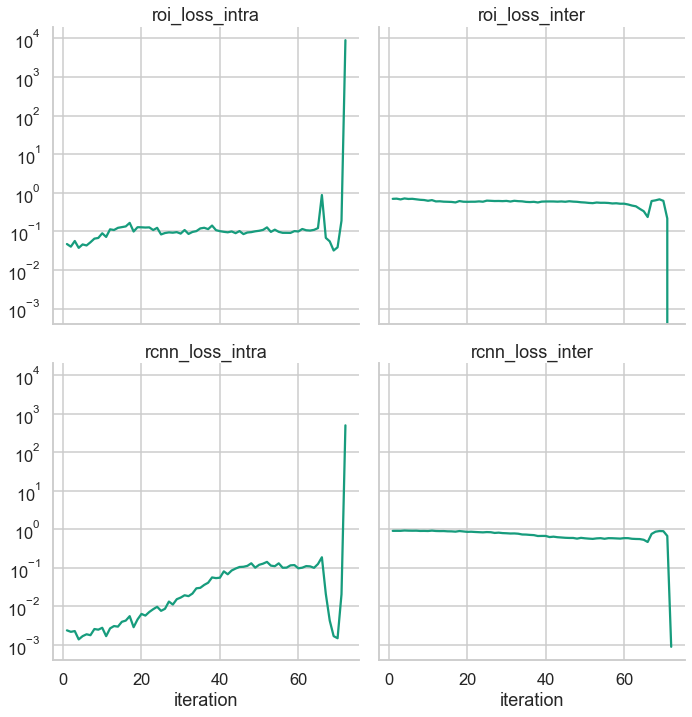

In [7]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'std']]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['i', 'mode'], ['roi_loss_intra', 'roi_loss_inter', 'rcnn_loss_intra', 'rcnn_loss_inter'], logs, get_max=True)

g = sb.relplot(data=df, x='occurrence', y='value', kind='line', col='metric', height=5, aspect=1., col_wrap=2)
g.set_axis_labels('iteration', '')
g.set_titles(col_template='{col_name}', row_template='')
plt.yscale('log')

## different distance metrics
We suspect the training problem is due to bad loss-balancing. Instead of trying to fix this directly, we try to use different distance metrics so that the losses are normalized better. Indeed, the model is able to train with these distances, but the overall performance is not improved.

[{'bbox_mAP_50': (25.0, 0.85)}, {'bbox_mAP_50': (4.0, 0.839)}, {'bbox_mAP_50': (38.0, 0.846)}, {'bbox_mAP_50': (25.0, 0.847)}]


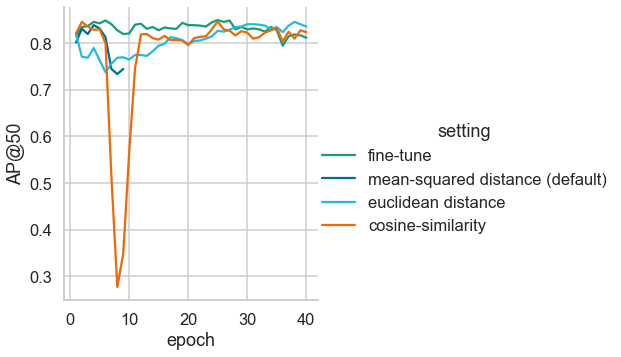

In [1]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_ft_80_step40_seeded.log', 'fine-tune'],
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetector_seed.log', 'fine-tune1'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'mean-squared distance (default)'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalseeuclidean_seed.log', 'euclidean distance'],     # -> might have worked with more epochs, most "well-behaved" loss, all losses decrease
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsecosine_seed.log', 'cosine-similarity'],
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalseeuclidean_seed.log', 'euclidean distance RCNN 100:1'],# doesn't train
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsecosine_seed.log', 'cosine-similarity RCNN 100:1'],# some training problem
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsecosine_seed_autoallinit.log', 'loss-balancing all init 0.2 cosine'],
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalseeuclidean_seed_autoallinit.log', 'loss-balancing all init 0.2 euclidean'],
]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=40], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

## automatic loss-balancing
We suspect the problem is due to poorly-balanced losses and first try a method for automatic loss-balancing. With simple initialization the method is not able to outperform manual balancing or even the fine-tuning baseline.

Looking at the resulting magnitudes, one problem might be the greedy over-emphasis of the RCNN inter-class loss that, when optimized alone, can increase the performance by helping classification in the head.

As a counter-measure, we try using auto-balancing on top of the manual optimum, but performance still falls short of normal training, even when training for twice the number of epochs.

As a last experiment, we try initializing the weights for auto-balancing as $\frac{1}{n_\text{tasks}} = 0.2$ just like in the paper. This leads to stable training but not to improvements over the baseline.

Combining the initialization, balancing of all losses, and training for 80+ epochs on top of the manually-obtained parameters might lead to improvement, but at that point, we might just as well not use it.

[{'bbox_mAP_50': (25.0, 0.85)}, {'bbox_mAP_50': (29.0, 0.835)}, {'bbox_mAP_50': (40.0, 0.783)}]


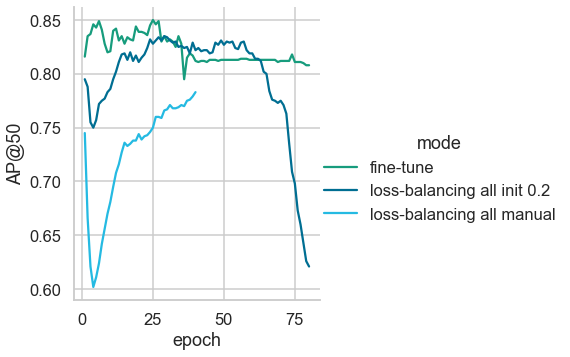

In [26]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_ft_80_step40_seeded.log', 'fine-tune'],
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing'],
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing 0.1'],
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoallinit.log', 'loss-balancing all init 0.2'],
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all manual'],
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter0001nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all inter 0001']
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptiveAutoBalance_10_01_100_01_fclayer_gTrue_seed.log', 'loss-balancing all manual'],
        ]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['mode'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='mode')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

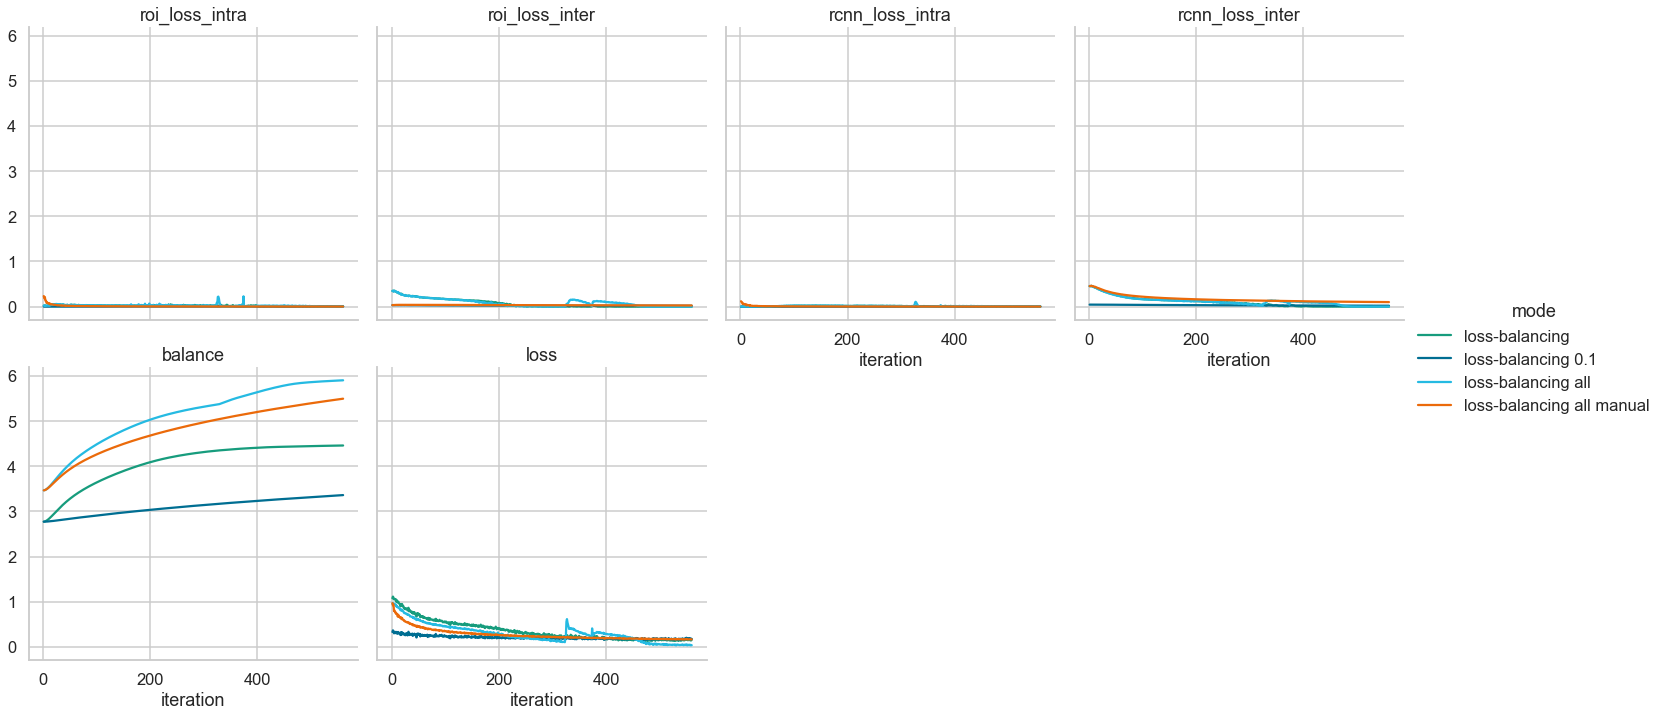

In [88]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing'],
        ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing 0.1'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all'],
        ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all manual']]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['mode'], ['roi_loss_intra', 'roi_loss_inter', 'rcnn_loss_intra', 'rcnn_loss_inter', 'balance', 'loss'], logs, get_max=True)

g = sb.relplot(data=df, x='occurrence', y='value', kind='line', hue='mode', col='metric', height=5, aspect=1., col_wrap=4)
g.set_axis_labels('iteration', '')
g.set_titles(col_template='{col_name}', row_template='')
# plt.yscale('log')

In [8]:
from log_analysis import *

log = 'GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoall.log'
# log = 'GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed_autoall.log'

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

weight_dict = keys_from_log(log, ['w old', 'w ROI intra', 'w ROI inter', 'w RCNN intra', 'w RCNN inter'])

print([weight_dict[k][-1] for k in weight_dict.keys()])

# g = sb.relplot(data=df, x='occurrence', y='value', kind='line', hue='mode', col='metric', height=5, aspect=1., col_wrap=4)
# g.set_axis_labels('iteration', '')
# g.set_titles(col_template='{col_name}', row_template='')
# plt.yscale('log')

[0.2121153473854065, 0.3209385871887207, 0.16771206259727478, 0.39049798250198364, 0.1356126219034195, 4464]


## manual loss-balancing
Then we manually find the optimum. For this, we first try to narrow down the problem, and find that the inter-class and intra-class losses can be trained individually, but not simultaneously:

[{'bbox_mAP_50': (5.0, 0.845)}, {'bbox_mAP_50': (2.0, 0.84)}, {'bbox_mAP_50': (32.0, 0.875)}, {'bbox_mAP_50': (4.0, 0.856)}]


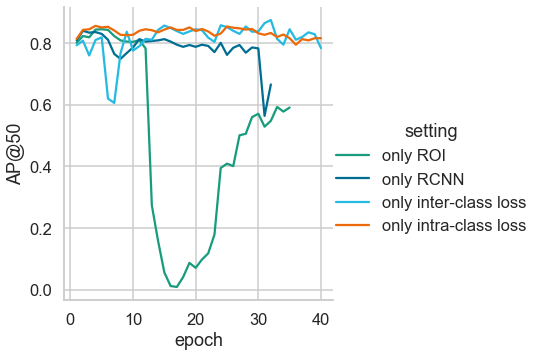

In [94]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra1inter1nFalsegtFalsemean_squared_seed.log', 'only ROI'],   # -> unstable, but eventual improvement, might have worked with more epochs
        ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'only RCNN'],  # -> no improvement, losses explode
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra0inter1nFalsegtFalsemean_squared_seed.log', 'only inter-class loss'], # -> 0.875!
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter0nFalsegtFalsemean_squared_seed.log', 'only intra-class loss'], # -> 0.856
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn10intra1inter1nFalsegtFalsemean_squared_seed.log', 'RCNN×10'],# -> explode
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn100intra1inter1nFalsegtFalsemean_squared_seed.log', 'RCNN×100'],# -> explode
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1000intra1inter1nFalsegtFalsemean_squared_seed.log', 'RCNN×1000'],# -> explode
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra10inter0nFalsegtFalsemean_squared_seed.log', '10:0'],# -> 0.855
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra0inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', '0:1 ROI'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra0inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', '0:1 RCNN'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra0inter01nFalsegtFalsemean_squared_seed.log', 'a', '0', '0:0.1'],# slightly worse
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra0inter10nFalsegtFalsemean_squared_seed.log', 'a', '0', '0:10'],# doesn't train
        ]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

Based on this, we tweak the balancing between the two loss components to find an optimum. We assume this is indepent of where we employ the loss, so we test only on the RCNN loss. We find that a ratio of $1000:1$ with a weight for RCNN of $0.1$ works best.

Even though inter-class loss is close to 1 (maximum, i.e. almost no distance between classes), it acts as regularization. Setting its influence even lower leads to worse performance.

[{'bbox_mAP_50': (25.0, 0.863)}, {'bbox_mAP_50': (25.0, 0.873)}, {'bbox_mAP_50': (25.0, 0.861)}, {'bbox_mAP_50': (4.0, 0.866)}, {'bbox_mAP_50': (4.0, 0.851)}]


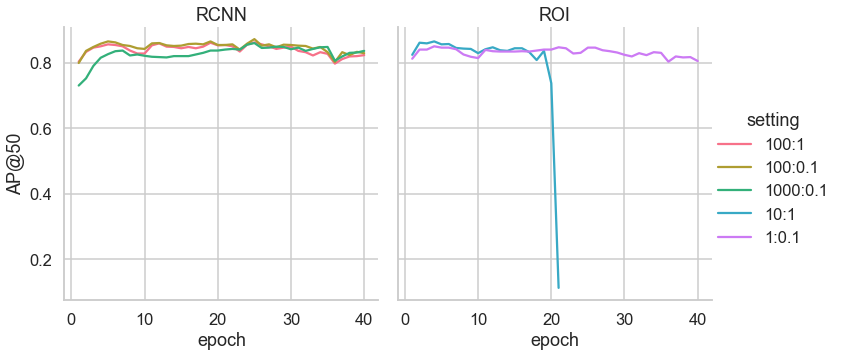

In [20]:
from log_analysis import *

logs = [# __:10
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn10intra10inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '100:10'],# doesn't train
        # ['GPA/tuning/coco_piropo_100a_da10roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '1000:10'],# doesn't train
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn10intra1000inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '10000:10'],# doesn't train
        # __:1
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra10inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '10:1'],# -> 0.846
        ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed0.log', 'RCNN', '100:1'],# -> 0.863!
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra1000inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '1000:1'],# -> 0.857
        # __:0.1
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn01intra10inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '1:0.1'],
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '10:0.1'],# no improvement
        ['GPA/tuning/coco_piropo_100a_da1roi0rcnn01intra1000inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '100:0.1'],# -> 0.873 !
        ['GPA/tuning/coco_piropo_100a_da1roi0rcnn01intra10000inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '1000:0.1'],
        # __:0.01
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn001intra10inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '0.1:0.01'],
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn001intra100inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '1:0.01'],
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn001intra1000inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '10:0.01'],
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn001intra1000inter1nFalsegtFalsemean_squared_seed.log', 'RCNN', '100:0.01'],
        # ROI
        # __:1
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_1_0_0_fclayer_gTrue_seed.log', 'ROI', '10:1'],
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra100inter1nFalsegtFalsemean_squared_seed.log', 'ROI', '100:1'],# worse
        # __:0.1
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_1_01_0_0_fclayer_gTrue_seed.log', 'ROI', '1:0.1'],
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn0intra100inter1nFalsegtFalsemean_squared_seed.log', 'ROI', '10:0.1 a'],# 0.865!
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra10inter01nFalsegtFalsemean_squared_seed.log', 'ROI', '10:0.1 b'],# 0.869!
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_100_01_0_0_fclayer_gTrue_seed.log', 'ROI', '100:0.1'],
        # __:0.01
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_01_001_0_0_fclayer_gTrue_seed.log', 'ROI', '0.1:0.01'],
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra1inter001nFalsegtFalsemean_squared_seed.log', 'ROI', '1:0.01'],# slight improvement
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_001_0_0_fclayer_gTrue_seed.log', 'ROI', '10:0.01'],
        ]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['head', 'setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='setting', col='head')
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')
print(maxs)

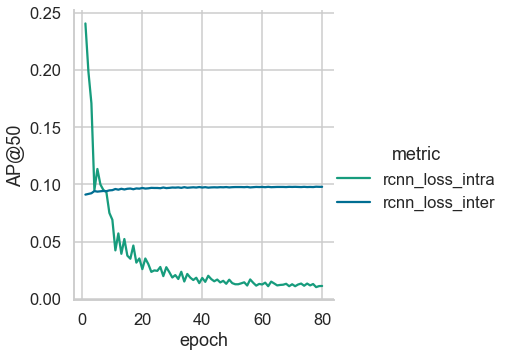

In [99]:
from log_analysis import *
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [['GPA/tuning/coco_piropo_100a_da1roi0rcnn01intra1000inter1nFalsegtFalsemean_squared_seed.log', '0.1×1000:1']]

df, maxs = df_from_log(['setting'], ['rcnn_loss_intra', 'rcnn_loss_inter'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='metric', height=5, aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')

We then try to find the best combination of ROI + RCNN. We assume the same ratio of intra-class to inter-class loss for adaptation on ROI. The best setting is $0.1:1$. If we allow for different ratios, $10:0.1$ performs very well on ROI as well and brings all the losses to the same order of magnitude.

[{'bbox_mAP_50': (25.0, 0.881)}, {'bbox_mAP_50': (25.0, 0.882)}]


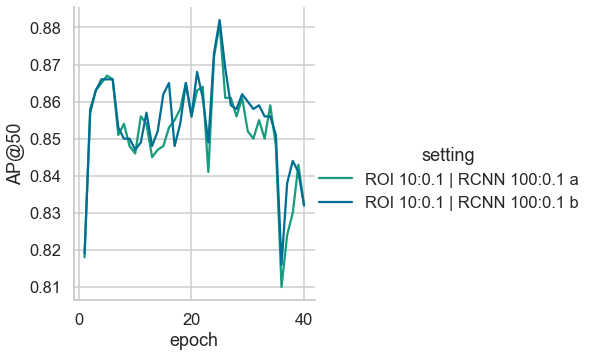

In [24]:
from log_analysis import *

logs = [# ROI × 0.01
        # ['GPA/tuning/coco_piropo_100a_da1roi001rcnn1intra100inter01nFalsegtFalsemean_squared_seed.log', 'ROI 1:0.001 | RCNN 100:0.1'],
        # ROI × 0.1        
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra1inter001nFalsegtFalsemean_squared_seed.log', 'a', '0', 'ROI × 01 1:0.01'],
        # ['GPA/tuning/coco_piropo_100a_da01roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'ROI × 01 10:0.1 a'],
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra10inter01nFalsegtFalsemean_squared_seed.log', 'a', '0', 'ROI × 01 10:0.1 b'],
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'ROI × 0.1 100:1'],# -> 0.871!
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter01nFalsegtFalsemean_squared_seed.log', 'ROI  10:0.01 | RCNN 100:0.1'],# -> 0.882!
        # ROI × 1
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'ROI × 1 10:0.1'],# -> 0.867!
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'ROI × 1 100:1'],# deteriorates
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra100inter01nFalsegtFalsemean_squared_seed.log', 'ROI 100:0.1 | RCNN 100:0.1'],
        # ROI × 10
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn01intra100inter1nFalsegtFalsemean_squared_seed.log', 'ROI × 10 10:0.1'],# much worse
        # ['GPA/tuning/coco_piropo_100a_da1roi10rcnn1intra100inter01nFalsegtFalsemean_squared_seed.log', 'ROI × 10 100:0.1'],# doesn't train
        # custom
        ['GPA/tuning/coco_piropo_100a_da0roi0rcnn0intra0inter0nFalsegtFalsemean_squared_seed_custom.log', 'ROI 10:0.1 | RCNN 100:0.1 a'],# slight improvement
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed.1.log', 'ROI 10:0.1 | RCNN 100:0.1 b'],
        ]
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

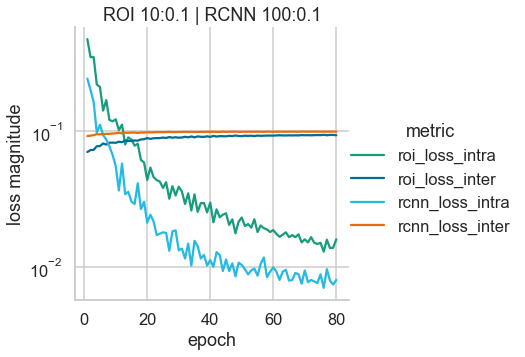

In [6]:
from log_analysis import *
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [#['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter01nFalsegtFalsemean_squared_seed.log', 'ROI 10:0.01 | RCNN 100:0.1'],
        ['GPA/tuning/coco_piropo_100a_da0roi0rcnn0intra0inter0nFalsegtFalsemean_squared_seed_custom.log', 'ROI 10:0.1 | RCNN 100:0.1']]

df, maxs = df_from_log(['setting'], ['roi_loss_intra', 'roi_loss_inter', 'rcnn_loss_intra', 'rcnn_loss_inter'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='metric', col='setting', height=5, aspect=1.)
g.set_axis_labels('epoch', 'loss magnitude')
g.set_titles(col_template='{col_name}', row_template='')
plt.yscale('log')
g.savefig(f'images/tuning_best_losses.svg')

### conclusion
We found that the best setting is $10:0.1$ for ROI and $100:0.1$ for RCNN, when using the mean-squared distance. Below, we compare the result to the baseline and examine the effect on other metrics, not just AP@0.5.

By forcing the net to adapt to the domain, and by using early-stopping to optimize AP@.5, we can also decrase LAMR but sacrifice overall AP and AP@.75. This means that localizations generally get worse to allow for better detections in general.

We find that removing random rotation as data augmentation alleviates this problem and allows for better training in general, but also makes GPA somewhat useless overall. Only the settings of GPA still hold true: without balancing the losses properly, GPA is unable to train.

[{'bbox_mAP': (2.0, 0.514), 'bbox_mAP_75': (1.0, 0.568), 'bbox_mAP_50': (25.0, 0.85), 'LAMR': (4.0, 0.2074)}, {'bbox_mAP': (2.0, 0.527), 'bbox_mAP_75': (2.0, 0.576), 'bbox_mAP_50': (25.0, 0.882), 'LAMR': (25.0, 0.1849)}]


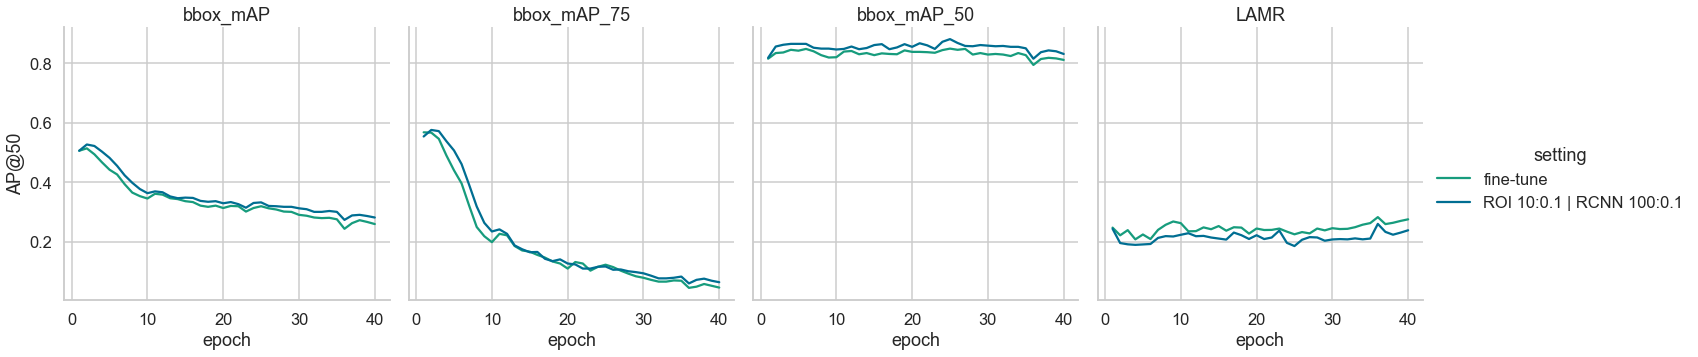

In [10]:
from log_analysis import *

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [
    ['GPA/tuning/coco_piropo_100a_ft_80_step40_seeded.log', 'fine-tune'],
    # ['GPA/tuning/coco_piropo_100a_TwoStageDetector_seed.log', 'fine-tune'],
    # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed.log', 'fine-tune 2'],
    ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed.1.log', 'ROI 10:0.1 | RCNN 100:0.1'],
]

df, maxs = df_from_log(['setting'], ['bbox_mAP', 'bbox_mAP_75', 'bbox_mAP_50', 'LAMR'],
                       logs,
                       get_max=True)

g = sb.relplot(data=df[df['occurrence'] <= 40],
               x='occurrence',
               y='value',
               kind='line',
               hue='setting',
               col='metric',
               height=5,
               aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')
print(maxs)
g.savefig(f'images/tuning_all_metrics.svg')

## Modifications
Based on the best version of "vanilla" GPA, we first try small modifications:

- Normalizing the aggregated instance-prototypes by the sum of the corresponding row in the adjacency matrix (as stated in the formula in the paper, but missing from the actual implementation) doesn't provide a benefit.
- Training on the source domain _and_ on the target domain as done in the original paper (most likely as a sort of regularisation, since the paper deals with unsupervised training), doesn't provide a benefit.

[{'bbox_mAP_50': (4.0, 0.85)}, {'bbox_mAP_50': (6.0, 0.851)}, {'bbox_mAP_50': (5.0, 0.852)}]


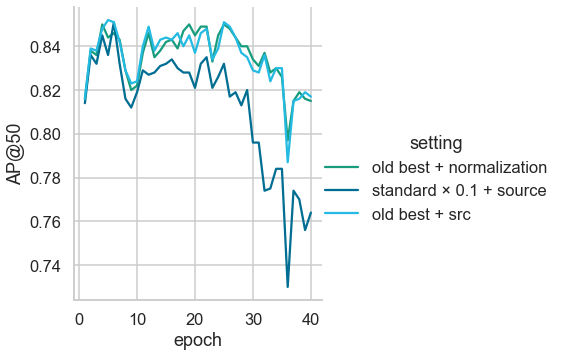

In [87]:
from log_analysis import *
logs = [# normalization
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nTruegtFalsemean_squared_seed.log', 'standard + normalization'],   # doesn't train
        ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nTruegtFalsemean_squared_seed.log', 'old best + normalization'],# no improvement
        # experiments about training on source domain
        ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_trainsrc.log', 'standard × 0.1 + source'],# no improvement
        ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed_trainsrc.log', 'old best + src'],# no improvement
        # ground-truth information
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtTruemean_squared_seed.log', 'a', '0', 'gt'],     # -> roi intra-loss explode
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nFalsegtTruemean_squared_seed.log', 'a', '0', 'best gt'],# doesn't train at all
    ]
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

### analyzing the role of the fc-layer
We are afraid that the fc-layer might "smooth" important discriminatory information from the original feature or otherwise distort it, such that the computed representations _after_ the fc-layer are aligned, but not the actual features in the network.

Removing it seems to help for GPA in the RCNN-head, but not after ROI-pooling, maybe since the features there are of a much larger size?

[{'bbox_mAP_50': (35.0, 0.86)}, {'bbox_mAP_50': (25.0, 0.875)}, {'bbox_mAP_50': (27.0, 0.862)}, {'bbox_mAP_50': (25.0, 0.874)}]


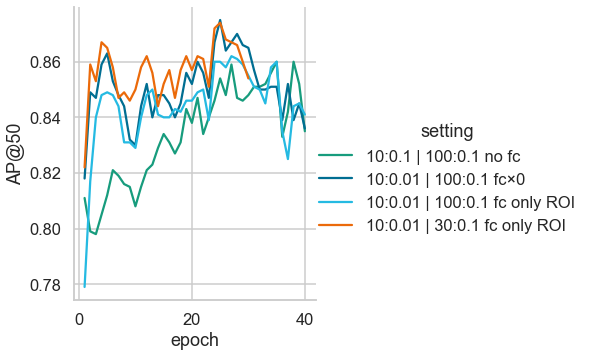

In [37]:
from log_analysis import *
logs = [# experiments about fc-layer
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seedapool.log', 'a', '0', 'RCNNinter100 avgpool'], # no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seedmpool.log', 'a', '0', 'RCNNinter100 maxpool'], # takes long to learn anything
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed_nofc.log', 'a', '0', 'RCNNinter100 nofc'], # 0.869!
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_none_gTrue_seed.log', '10:0.1 | 100:0.1 no fc'],
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_001_100_01_none_gTrue_seed.log', '10:0.01 | 100:0.1 no fc'],
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_01.log', '10:0.01 | 100:0.1 fc×0.1'],
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_0.log', '10:0.01 | 100:0.1 fc×0'],
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayerroi_gTrue_seed.log', '10:0.01 | 100:0.1 fc only ROI'],
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_30_01_fclayerroi_gTrue_seed.log', '10:0.01 | 30:0.1 fc only ROI'],
        # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayerrcnn_gTrue_seed.log', '10:0.01 | 100:0.1 fc only RCNN'],
        ]
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

[{'roi_loss_intra': (1.0, 0.4693), 'roi_loss_inter': (272.0, 0.0942), 'rcnn_loss_intra': (1.0, 0.2406), 'rcnn_loss_inter': (237.0, 0.0989)}, {'roi_loss_intra': (1.0, 0.4702), 'roi_loss_inter': (272.0, 0.0957), 'rcnn_loss_intra': (1.0, 0.6671), 'rcnn_loss_inter': (247.0, 0.0982)}, {'roi_loss_intra': (1.0, 1.301), 'roi_loss_inter': (275.0, 0.0929), 'rcnn_loss_intra': (1.0, 0.1926), 'rcnn_loss_inter': (196.0, 0.0992)}, {'roi_loss_intra': (63.0, 5.164), 'roi_loss_inter': (4.0, 0.7124), 'rcnn_loss_intra': (63.0, 0.503), 'rcnn_loss_inter': (4.0, 0.9268)}]


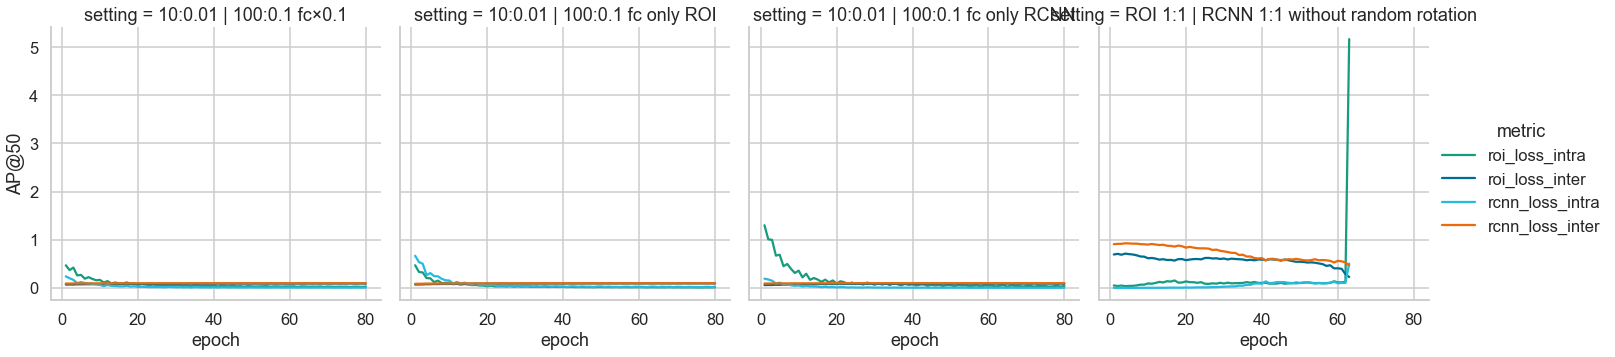

In [11]:
from log_analysis import *
logs = [  # experiments about fc-layer
    # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seedapool.log', 'a', '0', 'RCNNinter100 avgpool'], # no improvement
    # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seedmpool.log', 'a', '0', 'RCNNinter100 maxpool'], # takes long to learn anything
    # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed_nofc.log', 'a', '0', 'RCNNinter100 nofc'], # 0.869!
    # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_none_gTrue_seed.log', '10:0.1 | 100:0.1 no fc'],
    # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_001_100_01_none_gTrue_seed.log', '10:0.01 | 100:0.1 no fc'],
    [
        'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_01.log',
        '10:0.01 | 100:0.1 fc×0.1'
    ],
    # ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_0.log', '10:0.01 | 100:0.1 fc×0'],
    [
        'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayerroi_gTrue_seed.log',
        '10:0.01 | 100:0.1 fc only ROI'
    ],
    [
        'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayerrcnn_gTrue_seed.log',
        '10:0.01 | 100:0.1 fc only RCNN'
    ],
    [
        'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_1_1_1_1_fclayer_gTrue_seed_norot.log',
        'ROI 1:1 | RCNN 1:1 without random rotation'
    ]
]
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['roi_loss_intra', 'roi_loss_inter', 'rcnn_loss_intra', 'rcnn_loss_inter'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', col='setting', hue='metric')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

### understanding the role of prototype aggregation

[{'bbox_mAP_50': (25.0, 0.875)}, {'bbox_mAP_50': (26.0, 0.878)}]


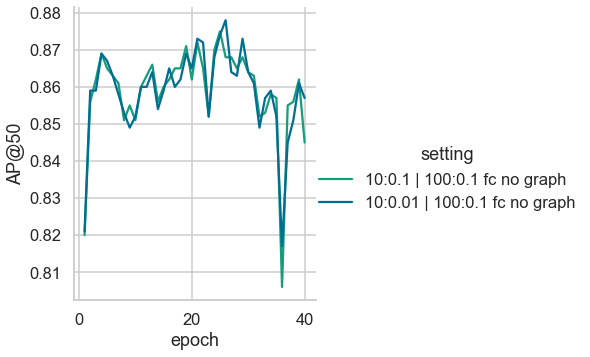

In [1]:
from log_analysis import *
logs = [# removing graph-based aggregation of instance-prototypes
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gFalse_seed.log', '10:0.1 | 100:0.1 fc no graph'],
        ['GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_001_100_01_fclayer_gFalse_seed.log', '10:0.01 | 100:0.1 fc no graph'],
        ]
sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['setting'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='setting')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

### removing random rotation

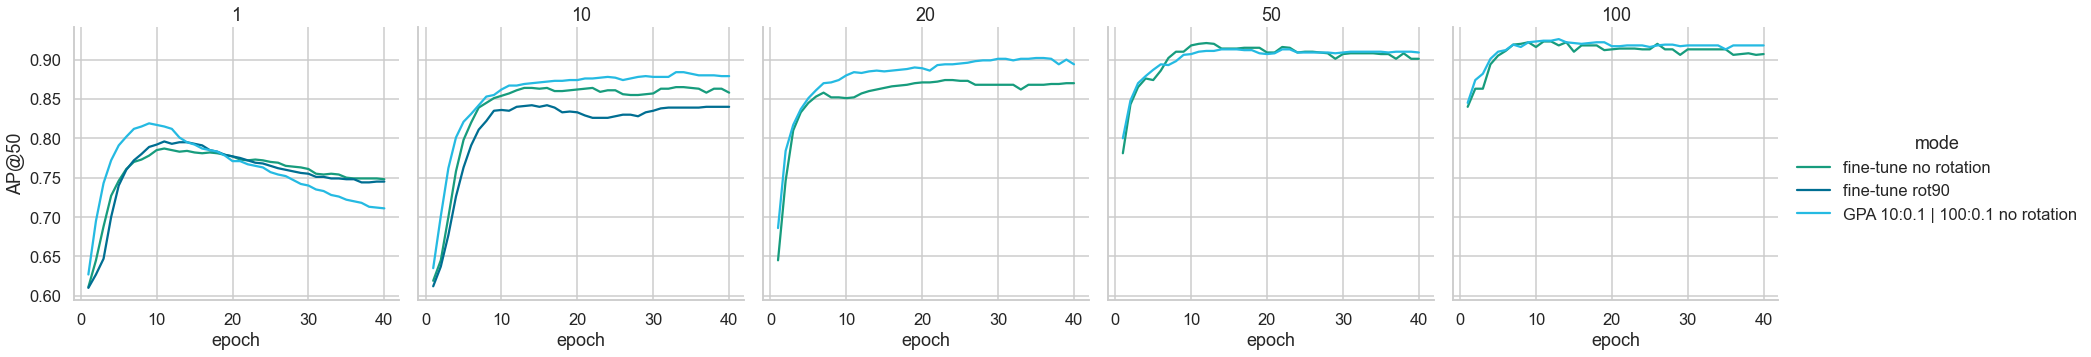

In [6]:
from log_analysis import *

logs = [
    # ['GPA/tuning/coco_piropo_1a_da0roi0rcnn0intra0inter0nFalsegtFalsemean_squared_seed.log', '1', 'fine-tune'],
    # [
    #     'GPA/tuning/coco_piropo_1a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', '1',
    #     'GPA 10:0.1 | 100:0.1'
    # ],
    [
        'GPA/tuning/coco_piropo_1a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '1',
        'fine-tune no rotation'
    ],
    ['GPA/tuning/coco_piropo_1a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_rot90.log', '1', 'fine-tune rot90'],
    [
        'GPA/tuning/coco_piropo_1a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log', '1',
        'GPA 10:0.1 | 100:0.1 no rotation'
    ],
    # ['GPA/tuning/coco_piropo_10a_da0roi0rcnn0intra0inter0nFalsegtFalsemean_squared_seed.log', '10', 'fine-tune'],
    # [
    #     'GPA/tuning/coco_piropo_10a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', '10',
    #     'GPA 10:0.1 | 100:0.1'
    # ],
    [
        'GPA/tuning/coco_piropo_10a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '10',
        'fine-tune no rotation'
    ],
    [
        'GPA/tuning/coco_piropo_10a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_rot90.log', '10',
        'fine-tune rot90'
    ],
    [
        'GPA/tuning/coco_piropo_10a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log', '10',
        'GPA 10:0.1 | 100:0.1 no rotation'
    ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '20',
        'fine-tune no rotation'
    ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log', '20',
        'GPA 10:0.1 | 100:0.1 no rotation'
    ],
    [
        'GPA/tuning/coco_piropo_50a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '50',
        'fine-tune no rotation'
    ],
    [
        'GPA/tuning/coco_piropo_50a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log', '50',
        'GPA 10:0.1 | 100:0.1 no rotation'
    ],
    # ['GPA/tuning/coco_piropo_100a_ft_80_step40_seeded.log', '100', 'fine-tune'],
    # [
    #     'GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed0.log', '100',
    #     'GPA 10:0.1 | 100:0.1'
    # ],
    [
        'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '100',
        'fine-tune no rotation'
    ],
    # [
    #     'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_rot90.log', '100',
    #     'fine-tune rot90'
    # ],
    [
        'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log', '100',
        'GPA 10:0.1 | 100:0.1 no rotation'
    ],
    # ['GPA/tuning/coco_piropo_500a_da0roi0rcnn0intra0inter0nFalsegtFalsemean_squared_seed.log', '500', 'fine-tune'],
    # [
    #     'GPA/tuning/coco_piropo_500a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', '500',
    #     'GPA 10:0.1 | 100:0.1'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_500a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '500',
    #     'fine-tune no rotation'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_1000a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', '1000',
    #     'fine-tune no rotation'
    # ],
]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['split', 'mode'], ['bbox_mAP_50'], logs, get_max=True)
# df, maxs = df_from_log(['split', 'mode'], ['bbox_mAP', 'bbox_mAP_75', 'bbox_mAP_50', 'LAMR'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence'] <= 40],
               x='occurrence',
               y='value',
               hue='mode',
               col='split',
            #    row='split',
               kind='line',
               height=5,
               aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template="{col_name}", row_template='training size {row_name}')

# arrow = {'arrowstyle': '-', 'color': 'black', 'ls': 'dotted'}
# loc = [[0, 0, 'u'], [0, 0, 'd'], [0, 1, 'd'], [0, 1, 'u'], [0, 2, 'u'], [0, 2, 'u'], [0, 3, 'u'], [0, 3, 'u']]
# for l, m in zip(loc, maxs):
#     x = m['bbox_mAP_50'][0]
#     y = m['bbox_mAP_50'][1]
#     if l is not None:
#         g.axes[l[0]][l[1]].plot(x, y, marker='o', markerfacecolor='none', markeredgecolor='black')
#         if l[2] == 'u':
#             g.axes[l[0]][l[1]].annotate(y, xy=(x, y), xytext=(x - 6.5, y + 0.01))
#         else:
#             g.axes[l[0]][l[1]].annotate(y, xy=(x, y - 0.004), xytext=(x, y - 0.17), arrowprops=arrow)
g.savefig(f'images/gpa_random_rotation_across_sizes.svg')


### adversarial loss
Replace the intra-inter-loss-pair with a domain discriminator, i.e. an adversarial loss. For these experiments, random rotation is removed as data augmentation step.


[{'bbox_mAP': (30.0, 0.566), 'bbox_mAP_75': (17.0, 0.632), 'bbox_mAP_50': (23.0, 0.874), 'LAMR': (24.0, 0.1594)}, {'bbox_mAP': (36.0, 0.576), 'bbox_mAP_75': (35.0, 0.648), 'bbox_mAP_50': (35.0, 0.902), 'LAMR': (36.0, 0.1378)}, {'bbox_mAP': (24.0, 0.559), 'bbox_mAP_75': (29.0, 0.646), 'bbox_mAP_50': (16.0, 0.873), 'LAMR': (19.0, 0.1668)}]


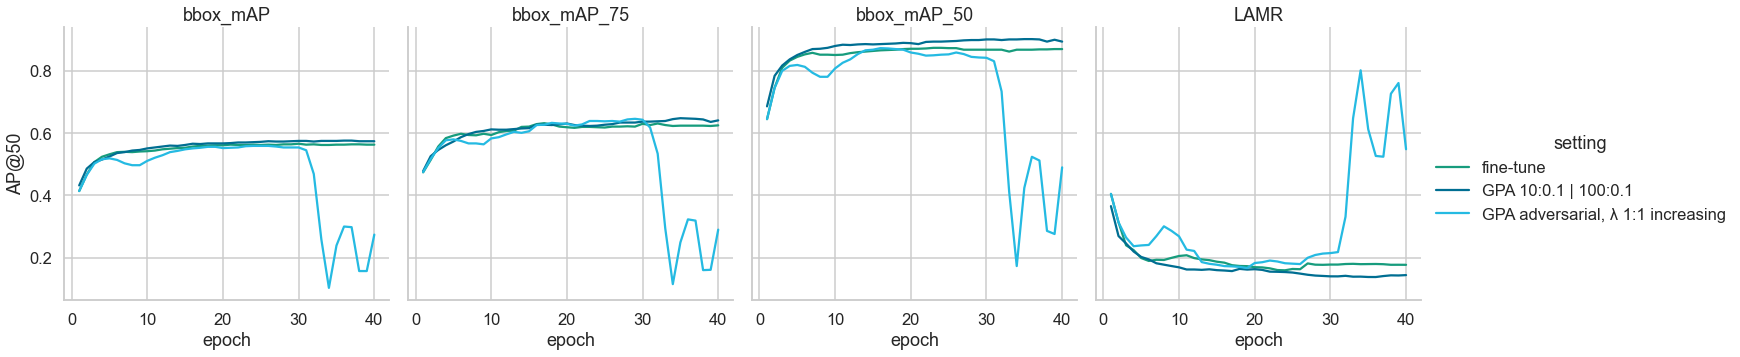

In [28]:
from log_analysis import *

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [
    # [
    #     'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log',
    #     'fine-tune'
    # ],
    # # [
    # #     'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log',
    # #     'ROI 10:0.1 | RCNN 100:0.1'
    # # ],
    # [
    #     'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_norot.log',
    #     'adversarial 1:1'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_norot_ann.log',
    #     'adversarial 1:1, increasing λ'
    # ],
    # # [
    # #     'GPA/tuning/coco_piropo_100a_TwoStageDetectorAdaptiveAdversarial_01_01_01_01_fclayer_gTrue_seed_norot.log',
    # #     'adversarial 0.1:0.1'
    # # ]
    ['GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', 'fine-tune'],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log',
        'GPA 10:0.1 | 100:0.1'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed.log',
    #     'GPA adversarial 1:1'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_01_01_01_01_fclayer_gTrue_seed.log',
    #     'GPA adversarial 0.1:0.1'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_incr.log',
    #     'GPA adversarial increasing λ 1:1'
    # ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_incr1.log',
        'GPA adversarial, λ 1:1 increasing'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_incr2.log',
    #     'GPA adversarial 1:1 increasing, lr × 10'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_incr3.log',
    #     'GPA adversarial 1:1 increasing, lr × 100'
    # ],
]

df, maxs = df_from_log(['setting'], ['bbox_mAP', 'bbox_mAP_75', 'bbox_mAP_50', 'LAMR'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence'] <= 40],
               x='occurrence',
               y='value',
               kind='line',
               hue='setting',
               col='metric',
               height=5,
               aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')
print(maxs)
# g.savefig(f'images/tuning_gpa_adversarial.svg')

[{'bbox_mAP': (23.0, 0.546), 'bbox_mAP_75': (24.0, 0.624), 'bbox_mAP_50': (37.0, 0.894), 'LAMR': (38.0, 0.1575)}, {'bbox_mAP': (26.0, 0.547), 'bbox_mAP_75': (22.0, 0.613), 'bbox_mAP_50': (45.0, 0.876), 'LAMR': (27.0, 0.187)}, {'bbox_mAP': (6.0, 0.536), 'bbox_mAP_75': (6.0, 0.59), 'bbox_mAP_50': (6.0, 0.861), 'LAMR': (6.0, 0.1882)}, {'bbox_mAP': (15.0, 0.563), 'bbox_mAP_75': (15.0, 0.627), 'bbox_mAP_50': (30.0, 0.895), 'LAMR': (30.0, 0.1479)}]


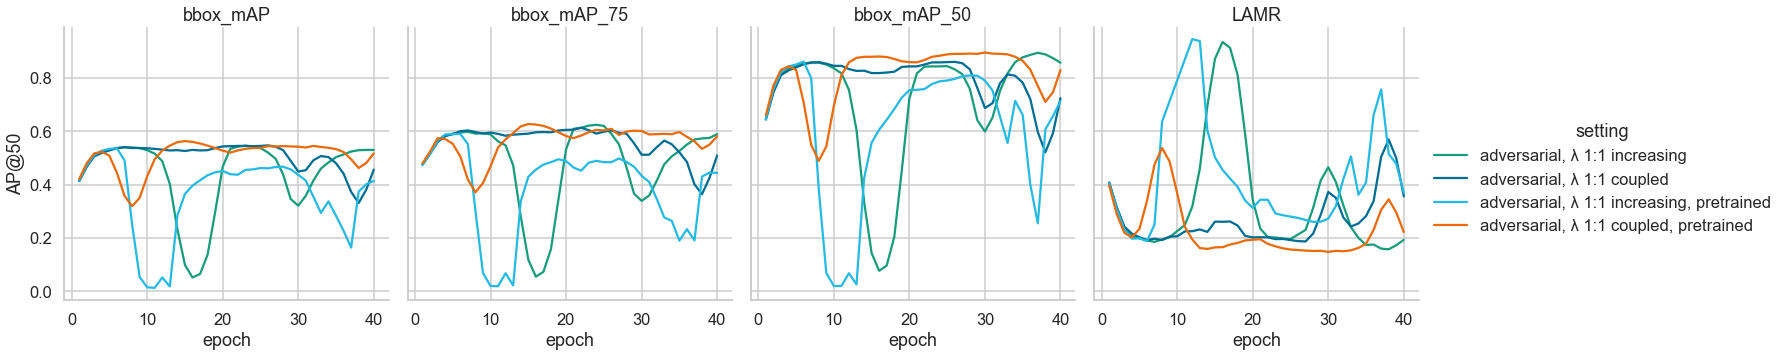

In [7]:
from log_analysis import *

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [
    # ['GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', 'fine-tune'],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log',
    #     'GPA 10:0.1 | 100:0.1'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_direct1.log',
    #     'fc → adversarial, λ 1:1 increasing, lr × 100'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_direct2.log',
    #     'fc → adversarial, λ 1:1 increasing'
    # ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct3.log',
        'adversarial, λ 1:1 increasing'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct4.log',
    #     'adversarial, λ 1:1 increasing, lr × 10'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct5_adv.log',
    #     'adversarial pretraining'
    # ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct10.log',
        'adversarial, λ 1:1 coupled'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct6.log',
    #     'adversarial, λ 1:1, pretrained'
    # ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct5.log',
        'adversarial, λ 1:1 increasing, pretrained'
    ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct7.log',
        'adversarial, λ 1:1 coupled, pretrained'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct8.log',
    #     'adversarial, λ 1:1 coupled, pretrained, , lr × 10'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct9.log',
    #     'adversarial, λ 1:1 coupled, pretrained CTD'
    # ],
]

df, maxs = df_from_log(['setting'], ['bbox_mAP', 'bbox_mAP_75', 'bbox_mAP_50', 'LAMR'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence'] <= 40],
               x='occurrence',
               y='value',
               kind='line',
               hue='setting',
               col='metric',
               height=5,
               aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')
print(maxs)
# g.savefig(f'images/tuning_gpa_adversarial.svg')

[{'roi_loss': (1.0, 0.7077), 'rcnn_loss': (1.0, 0.7195)}, {'roi_loss': (31.0, 1.3573), 'rcnn_loss': (37.0, 1.1476)}, {'roi_loss': (73.0, 1.1865), 'rcnn_loss': (38.0, 0.8485)}, {'roi_loss': (23.0, 3.1239), 'rcnn_loss': (23.0, 2.7847)}, {'roi_loss': (23.0, 1.837), 'rcnn_loss': (21.0, 1.8924)}]


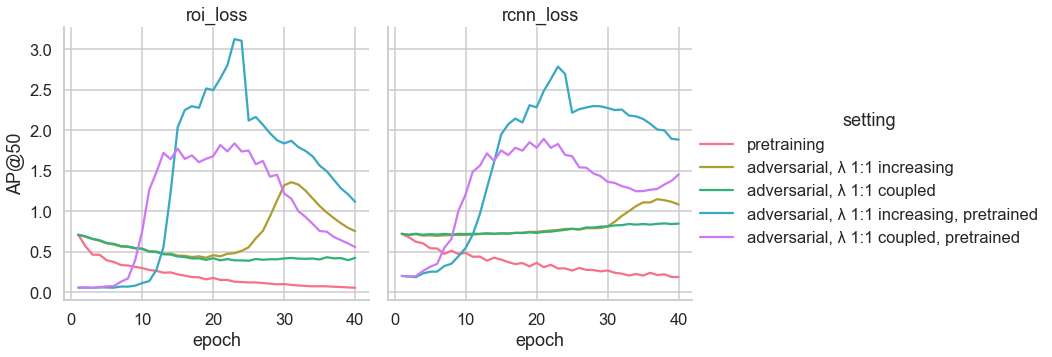

In [5]:
from log_analysis import *

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_incr1.log',
    #     'GPA adversarial, λ 1:1 increasing'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_direct1.log',
    #     'fc → adversarial, λ 1:1 increasing, lr × 100'
    # ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_fclayer_gTrue_seed_direct2.log',
    #     'fc → adversarial, λ 1:1 increasing'
    # ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct5_adv.log',
        'pretraining'
    ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct3.log',
        'adversarial, λ 1:1 increasing'
    ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct10.log',
        'adversarial, λ 1:1 coupled'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct4.log',
    #     'adversarial, λ 1:1 increasing, lr × 10'
    # ],

    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct5.log',
        'adversarial, λ 1:1 increasing, pretrained'
    ],
    # [
    #     'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct6.log',
    #     'adversarial, λ 1:1, pretrained'
    # ],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptiveAdversarial_1_1_1_1_none_gTrue_seed_direct7.log',
        'adversarial, λ 1:1 coupled, pretrained'
    ],
]

df, maxs = df_from_log(['setting'], ['roi_loss', 'rcnn_loss'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence'] <= 40],
               x='occurrence',
               y='value',
               kind='line',
               hue='setting',
               col='metric',
               height=5,
               aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')
print(maxs)
# g.savefig(f'images/tuning_gpa_adversarial.svg')

[{'bbox_mAP': (30.0, 0.566), 'bbox_mAP_75': (17.0, 0.632), 'bbox_mAP_50': (23.0, 0.874), 'LAMR': (24.0, 0.1594)}, {'bbox_mAP': (36.0, 0.576), 'bbox_mAP_75': (35.0, 0.648), 'bbox_mAP_50': (35.0, 0.902), 'LAMR': (36.0, 0.1378)}, {'bbox_mAP': (20.0, 0.569), 'bbox_mAP_75': (20.0, 0.657), 'bbox_mAP_50': (20.0, 0.882), 'LAMR': (19.0, 0.1593)}, {'bbox_mAP': (1.0, 0.568), 'bbox_mAP_75': (1.0, 0.652), 'bbox_mAP_50': (3.0, 0.883), 'LAMR': (2.0, 0.1574)}]


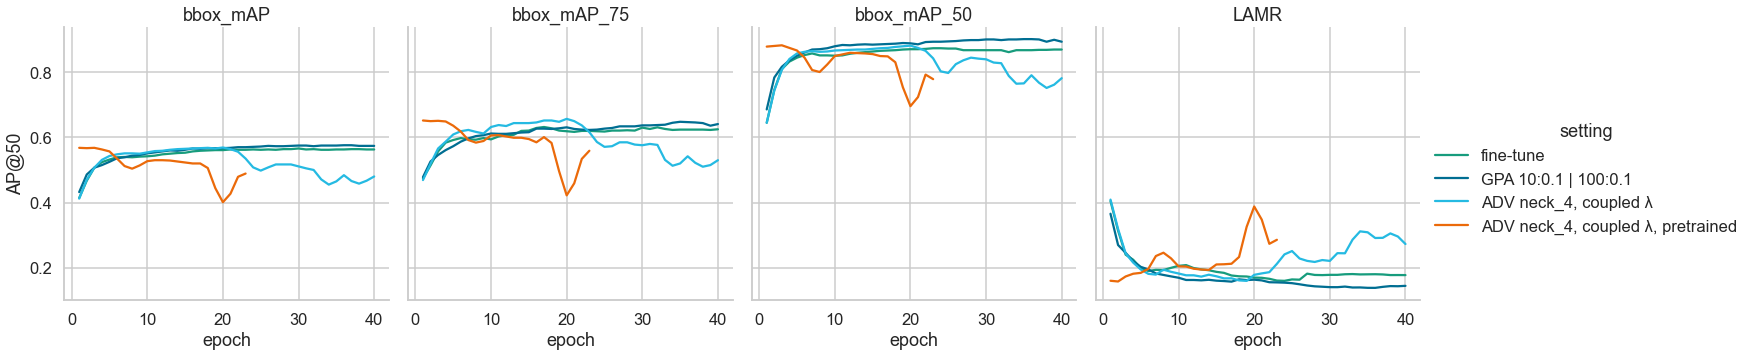

In [2]:
from log_analysis import *

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())
logs = [
    ['GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_0_0_0_0_fclayer_gTrue_seed_norot.log', 'fine-tune'],
    [
        'GPA/tuning/coco_piropo_20a_TwoStageDetectorAdaptive_10_01_100_01_fclayer_gTrue_seed_norot.log',
        'GPA 10:0.1 | 100:0.1'
    ],
    # ['GPA/tuning/coco_piropo_20a_TwoStageDetectorDA_seed_GPAtest.log', 'GPA 10:0.1 | 100:0.1 new'],
    # ['GPA/tuning/coco_piropo_20a_TwoStageDetectorDA_seed_GPAtest1.log', 'GPA 10:0.1 | 100:0.1 new'],
    # ['GPA/tuning/coco_piropo_20a_TwoStageDetectorDA_seed_GPAratio.log', "GPA 10:0.1 | 100:0.1 don't keep ratio"],
    # ['GPA/tuning/coco_piropo_20a_TwoStageDetectorDA_seed_GPAratiotest.log', "GPA 10:0.1 | 100:0.1 don't keep ratio (also in test)"],
    ['GPA/tuning/coco_piropo_20a_TwoStageDetectorDA_seed_ADVneck4.log', 'ADV neck_4, coupled λ'],
    ['GPA/tuning/coco_piropo_20a_TwoStageDetectorDA_ADVneck4_sp.log', 'ADV neck_4, coupled λ, pretrained'],
]

df, maxs = df_from_log(['setting'], ['bbox_mAP', 'bbox_mAP_75', 'bbox_mAP_50', 'LAMR'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence'] <= 40],
               x='occurrence',
               y='value',
               kind='line',
               hue='setting',
               col='metric',
               height=5,
               aspect=1.)
g.set_axis_labels('epoch', 'AP@50')
g.set_titles(col_template='{col_name}', row_template='')
print(maxs)
# g.savefig(f'images/tuning_gpa_adversarial.svg')

### utilizing ground-truth information